# Retention Time Preidiction 

This notebook is prepared to be run in Google [Colaboratory](https://colab.research.google.com/). In order to train the model faster, please change the runtime of Colab to use Hardware Accelerator, either GPU or TPU.

This notebook presents a short walkthrough the process of reading a dataset and training a model for retention time prediction. The dataset is an example dataset extracted from a ProteomTools dataset generated in the **Chair of Bioanalytics** at the **Technical University of Munich**.

The framework being used is a custom wrapper on top of Keras/TensorFlow. The working name of the package is for now DLOmix -  `dlomix`.

In [1]:
# install the DLOmix package in the current environment using pip

!python -m pip install -q git+https://github.com/wilhelm-lab/dlomix

The available modules in the framework are as follows:

In [1]:
import numpy as np
import pandas as pd
import dlomix
from dlomix import constants, data, eval, layers, models, pipelines, reports, utils
print([x for x in dir(dlomix) if not x.startswith("_")])

['constants', 'data', 'eval', 'layers', 'models', 'pipelines', 'reports', 'utils']


- `constants`: constants to be used in the framework (e.g. Aminoacid alphabet mapping)
- `data`:  classes for representing dataset, wrappers around TensorFlow Dataset
- `eval`: custom evaluation metrics implemented in Keras/TF to work as `metrics` for model training
- `layers`: custom layer implementation required for the different models
- `models`: different model implementations for Retention Time Prediction
- `pipelines`: complete pipelines to run a task (e.g. Retention Time prediction)
- `utils`: helper modules

**Note**: reports and pipelines are work-in-progress, some funtionalities are not complete.

## 1. Load Data

We can import the dataset class and create an object of type `RetentionTimeDataset`. This object wraps around TensorFlow dataset objects for training+validation or for testing. This can be specified by the arguments `val_ratio` and `test`.

In [2]:
from dlomix.data import RetentionTimeDataset

In [3]:
TRAIN_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_train_val.csv'
BATCH_SIZE = 64

rtdata = RetentionTimeDataset(data_source=TRAIN_DATAPATH,
                              seq_length=30, batch_size=BATCH_SIZE, val_ratio=0.2, test=False)

2022-02-09 13:23:48.619638: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-09 13:23:49.244115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14648 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1e:00.0, compute capability: 7.0


Now we have an RT dataset that can be used directly with standard or custom `Keras` models. This wrapper contains the splits we chose when creating it. In our case, they are training and validation splits. To get the TF Dataset, we call the attributes `.train_data` and `.val_data`. The length is now in batches (i.e. `total examples = batch_size x len`)

In [4]:
 "Training examples", BATCH_SIZE * len(rtdata.train_data)

('Training examples', 27136)

In [5]:
"Validation examples", BATCH_SIZE * len(rtdata.val_data)

('Validation examples', 6784)

## 2. Model

We can now create the model. We will use a simple Prediction with a conv1D encoder. It has the default working arguments, but most of the parameters can be customized.

**Note**: Important is to ensure that the padding length used for the dataset object is equal to the sequence length passed to the model.

In [6]:
from dlomix.models import RetentionTimePredictor

In [7]:
model = RetentionTimePredictor(seq_length=30)

## 3. Training

We can then train the model like a standard Keras model. The training parameters here are from Prosit, but other optimizer parameters can be used.  

In [8]:
#imports

from dlomix.eval import TimeDeltaMetric

In [9]:
# compile the model  with the optimizer and the metrics we want to use, we can add our custom timedelta metric

# you can also import tensorflow and build your custom optimizer object and pass it

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mean_absolute_error', TimeDeltaMetric()])

We store the result of training so that we can explore the metrics and the losses later. We specify the number of epochs for training and pass the training and validation data as previously described.

In [10]:
history = model.fit(rtdata.train_data,
                    validation_data=rtdata.val_data,
                    epochs=20)

2022-02-09 13:24:09.135721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-09 13:24:10.479844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


424/424 [==============================] - 6s 9ms/step - loss: 747.1149 - mean_absolute_error: 19.4802 - timedelta: 20.2240 - val_loss: 226.8938 - val_mean_absolute_error: 11.1885 - val_timedelta: 10.5352
Epoch 2/20
424/424 [==============================] - 3s 8ms/step - loss: 158.5717 - mean_absolute_error: 9.2104 - timedelta: 9.7483 - val_loss: 128.4731 - val_mean_absolute_error: 8.1324 - val_timedelta: 7.4543
Epoch 3/20
424/424 [==============================] - 3s 8ms/step - loss: 118.1288 - mean_absolute_error: 7.8045 - timedelta: 8.2744 - val_loss: 105.2108 - val_mean_absolute_error: 7.4071 - val_timedelta: 7.3659
Epoch 4/20
424/424 [==============================] - 3s 8ms/step - loss: 100.5556 - mean_absolute_error: 7.1255 - timedelta: 7.6109 - val_loss: 96.0209 - val_mean_absolute_error: 7.0648 - val_timedelta: 7.3047
Epoch 5/20
424/424 [==============================] - 3s 8ms/step - loss: 90.7466 - mean_absolute_error: 6.7168 - timedelta: 6.9966 - val_loss: 90.3429 - val_me

## 3. Testing and Reporting

We can create a test dataset to test our model. Additionally, we can use the reporting module to produce plots and evaluate the model.

Note: the reporting module is still in progress and some functionalities might easily break.

In [11]:
# create the dataset object for test data

TEST_DATAPATH = 'https://raw.githubusercontent.com/wilhelm-lab/dlomix/develop/example_dataset/proteomTools_test.csv'

test_rtdata = RetentionTimeDataset(data_source=TEST_DATAPATH,
                              seq_length=30, batch_size=32, test=True)

In [12]:
# use model.predict from keras directly on the testdata

predictions = model.predict(test_rtdata.test_data)

# we use ravel from numpy to flatten the array (since it comes out as an array of arrays)
predictions = predictions.ravel()

In [13]:
# we can get the targets of a specific split to calcualte evaluation metrics against predictions
# the get_split_targets function from the RetentionTime dataset does this

test_targets = test_rtdata.get_split_targets(split="test")

In [14]:
test_targets, predictions

(array([160.87262216,  -9.96731383,   1.6301965 , ...,  43.60962035,
         29.89127059,  70.90945116]),
 array([148.74487  , -18.871372 ,   2.7950273, ...,  40.49403  ,
         28.424765 ,  70.51668  ], dtype=float32))

In [15]:
from dlomix.reports import RetentionTimeReport

In [16]:
# create a report object by passing the history object and plot different metrics
report = RetentionTimeReport(output_path="./output", history=history)

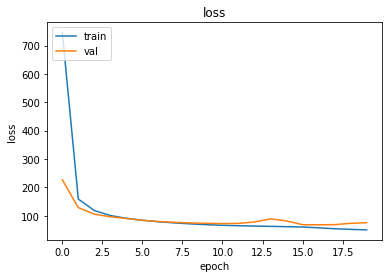

In [17]:
report.plot_keras_metric("loss")

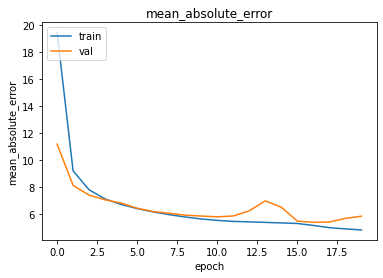

In [18]:
report.plot_keras_metric("mean_absolute_error")

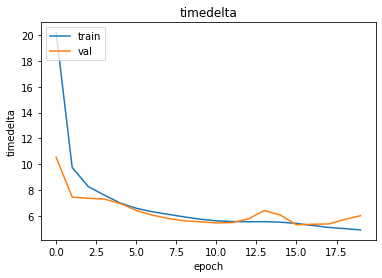

In [19]:
report.plot_keras_metric("timedelta")

In [20]:
# calculate R2  given the targets and the predictions of the test data
report.calculate_r2(test_targets, predictions)

0.9629874814557413

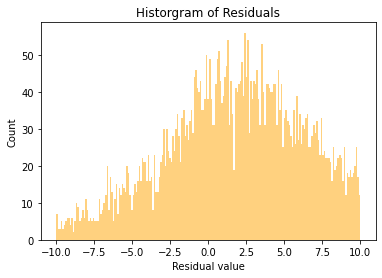

In [27]:
report.plot_residuals(test_targets, predictions)

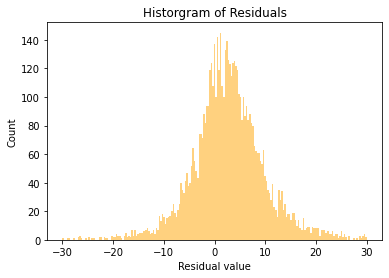

In [28]:
report.plot_residuals(test_targets, predictions, xrange=(-30, 30))

We can also produce a complete report with all the relevant plots in one PDF file by calling the `generate_report` function.

KeyError: 'val_val_loss'

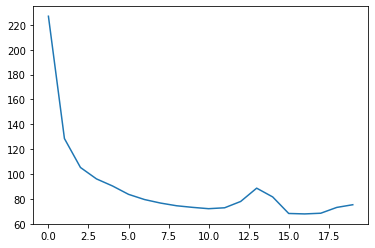

In [29]:
report.generate_report(test_targets, predictions)

## 4. Saving and Loading Models

Models can be saved normally the same Keras models would be saved. It is better to save the weights and the not the model since it makes it easier and more platform-indepdent when loading the model again. The extra step needed is to create a model object and then load the weights.

In [30]:
# save the model weights

save_path = "./output/rtmodel"
model.save_weights(save_path)

In [31]:
# models can be later loaded by creating a model object and then loading the weights

trained_model = RetentionTimePredictor(seq_length=30)
trained_model.load_weights(save_path)

We can compare the predictions to make sure that the model was loaded correctly.

In [33]:
new_predictions = trained_model.predict(test_rtdata.test_data)

In [34]:
new_predictions = new_predictions.ravel()

In [35]:
# confirm all old and new predictions are the same
np.allclose(predictions, new_predictions)

True

In [36]:
results_df = pd.DataFrame({"sequence": test_rtdata.sequences,
                           "irt": test_rtdata.targets,
                           "predicted_irt": predictions})

results_df.to_csv("./output/predictions_irt.csv", index=False)

In [37]:
pd.read_csv("./output/predictions_irt.csv")

,sequence,irt,predicted_irt
0,IAAGLGPSYSGSLLLFDALR,160.872622,148.744870
1,KKISEEDLR,-9.967314,-18.871372
2,HAFTCRVAGGPGTPR,1.630197,2.795027
3,LNDGHFMPVLGFGTYAPPEVPR,108.566269,109.863860
4,MITPEDVK,14.768607,14.502388
...,...,...,...
5976,VAPPGLTQIPQIQK,83.372074,75.719320
5977,SELGSFITDYFQNQLLAK,161.185058,156.062450
5978,TYRPLVNDISEAK,43.609620,40.494030
5979,EITNQVVPQER,29.891271,28.424765


In [1]:
#https://docs.fast.ai/tutorial.text
from fastai.text.all import *

In [3]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/home/ash022/.fastai/data/imdb/tmp_clas'),Path('/home/ash022/.fastai/data/imdb/README'),Path('/home/ash022/.fastai/data/imdb/train'),Path('/home/ash022/.fastai/data/imdb/imdb.vocab'),Path('/home/ash022/.fastai/data/imdb/tmp_lm'),Path('/home/ash022/.fastai/data/imdb/test'),Path('/home/ash022/.fastai/data/imdb/unsup')]

In [4]:
(path/'train').ls()

(#4) [Path('/home/ash022/.fastai/data/imdb/train/unsupBow.feat'),Path('/home/ash022/.fastai/data/imdb/train/labeledBow.feat'),Path('/home/ash022/.fastai/data/imdb/train/pos'),Path('/home/ash022/.fastai/data/imdb/train/neg')]

In [5]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
dls.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxunk "" and "" beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this movie . \n\n "" zombi 3 "" in a bizarre way is actually linked to the infamous xxmaj lucio xxmaj fulci "" zombie "" franchise which began in 1979 . xxmaj similarly compared to "" zombie "" , "" zombi 3 "" consists of a threadbare plot and a handful of extremely bad actors that keeps this ' horror ' trash barely afloat . xxmaj the gore is nearly non - existent ( unless one is frightened of people running around with",neg
2,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the oddest possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is innate , contained within the characters and the setting and the plot … which is highly believable to boot . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",pos
3,"xxbos xxup anchors xxup aweigh sees two eager young sailors , xxmaj joe xxmaj brady ( gene xxmaj kelly ) and xxmaj clarence xxmaj doolittle / xxmaj brooklyn ( frank xxmaj sinatra ) , get a special four - day shore leave . xxmaj eager to get to the girls , particularly xxmaj joe 's xxmaj lola , neither xxmaj joe nor xxmaj brooklyn figure on the interruption of little xxmaj navy - mad xxmaj donald ( dean xxmaj stockwell ) and his xxmaj aunt xxmaj susie ( kathryn xxmaj grayson ) . xxmaj unexperienced in the ways of females and courting , xxmaj brooklyn quickly enlists xxmaj joe to help him win xxmaj aunt xxmaj susie over . xxmaj along the way , however , xxmaj joe finds himself falling for the gal he thinks belongs to his best friend . xxmaj how is xxmaj brooklyn going to take",pos
4,"xxbos xxmaj it has said that xxmaj the xxmaj movies and xxmaj baseball both thrived during xxmaj the xxmaj great xxmaj depression . xxmaj it appears that the grim realities of a xxmaj nation caught up in the aftermath of this xxmaj economic xxmaj disaster created a need for occasional relief for the populace . a temporary escape could be found in the on going soap opera that is xxmaj baseball . \n\n xxmaj likewise , an occasional excursion of 2 or 3 hours into the darkened xxunk of the xxmaj cinema . xxmaj the presence of a xxmaj radio in just about everyone 's house hold kept xxmaj depression xxmaj era xxmaj america at once attuned to xxmaj world 's xxmaj events and provided many a xxmaj drama and ( especially ) xxmaj comedy xxmaj shows for a pleasant interlude from harsh reality . \n\n xxmaj the literature of",pos
5,"xxbos xxmaj that wor

In [6]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [7]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.467936,0.399168,0.820640,01:22


epoch,train_loss,valid_loss,accuracy,time
0,0.315006,0.338476,0.850720,02:34
1,0.241659,0.208572,0.919480,02:35
2,0.183976,0.188964,0.926960,02:34
3,0.153797,0.197588,0.926000,02:34


In [10]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.078074,0.226930,0.930280,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.093795,0.313647,0.893240,02:34
1,0.107867,0.212718,0.925960,02:35
2,0.062316,0.253922,0.927200,02:34
3,0.049545,0.263144,0.927960,02:34


In [ ]:
learn.show_results()

In [ ]:
#learn.predict("I really liked that movie!")
learn.predict("PEPTIDE")

In [ ]:
imdb = DataBlock(blocks=(TextBlock.from_folder(path), CategoryBlock),
                 get_items=get_text_files,
                 get_y=parent_label,
                 splitter=GrandparentSplitter(valid_name='test'))

In [ ]:
dls = imdb.dataloaders(path)

In [ ]:
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid_pct=0.1)

In [ ]:
dls_lm.show_batch(max_n=5)